---

# **Text-to-Speech System Using Deep Learning**

## **Introduction**
This project implements a basic **Text-to-Speech (TTS)** system, which converts textual input into audio waveforms. It uses a deep learning-based approach to predict mel spectrograms from text sequences. The mel spectrograms are then converted into audio waveforms using a vocoder. This system is a simplified demonstration of TTS pipelines, such as those found in speech synthesis systems like Tacotron.

### **Objective**
To design a neural network that maps textual input to audio output by predicting mel spectrograms, which are then converted into audible speech.

---

## **Project Components**

### **1. Dataset Preparation**
To demonstrate the TTS pipeline, a **dummy dataset** is generated, consisting of:
- **Text Data**: Random sequences of integers representing characters or phonemes.
- **Audio Data**: Randomly generated waveforms.
This setup simulates real-world data while focusing on the model and methodology.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GRU, Dense, BatchNormalization, ReLU, Flatten
from tensorflow.keras.models import Model
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# Step 1: Dataset Preparation (Dummy Dataset)
# Replace this with a real TTS dataset
def generate_dummy_data(num_samples=1000, max_text_len=30, audio_len=16000):
    # Generate dummy text data (character sequences as integers)
    text_data = np.random.randint(1, 50, size=(num_samples, max_text_len))  # Replace with real text preprocessing
    # Generate dummy audio data (waveform samples)
    audio_data = np.random.rand(num_samples, audio_len).astype(np.float32)
    return text_data, audio_data

text_data, audio_data = generate_dummy_data()

### **2. Text Preprocessing**
The textual input is processed into sequences and embedded using an embedding layer. The vocabulary size and embedding dimension are configurable.

In [3]:
# Step 2: Text Preprocessing
# Convert text to sequences and create embeddings
vocab_size = 50  # Number of unique characters or phonemes
embedding_dim = 128

### **3. Audio Preprocessing**
The audio waveforms are transformed into **mel spectrograms**, which are 2D representations of frequency vs. time. 
- **Mel Spectrogram Conversion**: Converts waveforms into a time-frequency representation.
- **Padding/Truncation**: Ensures fixed dimensions for the neural network input.

In [7]:
# Step 3: Audio Preprocessing
# Convert audio waveforms to mel-spectrograms
def waveform_to_melspectrogram(waveform, sr=22050, n_mels=80):
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db.T  # Transpose to match time-major format
    
def preprocess_audio(audio_data, sr=22050, n_mels=80, fixed_time_steps=30):
    mel_specs = [waveform_to_melspectrogram(waveform, sr, n_mels) for waveform in audio_data]
    # Pad or truncate mel-spectrograms to `fixed_time_steps`
    processed_mel_specs = np.array([
        np.pad(mel, ((0, max(0, fixed_time_steps - mel.shape[0])), (0, 0)), mode='constant')[:fixed_time_steps]
        for mel in mel_specs
    ])
    return processed_mel_specs

mel_spectrograms = preprocess_audio(audio_data, fixed_time_steps=text_data.shape[1])  # Match text sequence length


# Verify Data Shapes
print("Text data shape:", text_data.shape)  # (num_samples, max_text_len)
print("Mel-spectrogram shape:", mel_spectrograms.shape)  # (num_samples, time_steps, n_mels)

Text data shape: (1000, 30)
Mel-spectrogram shape: (1000, 30, 80)


### **4. Model Architecture**
The TTS model is designed to map text sequences to mel spectrograms:
- **Input**: Text sequences represented as integers.
- **Embedding Layer**: Converts integers into dense vector representations.
- **Convolutional Layer**: Extracts local features from sequences.
- **GRU Layer**: Processes sequential dependencies in the text.
- **Dense Output Layer**: Predicts the mel spectrogram for each time step.
- **Activation**: ReLU ensures non-linearity in the predicted spectrogram.

In [8]:
# Step 4: Model Design
def build_tts_model(vocab_size, embedding_dim, input_length, n_mels):
    # Text Input
    text_input = Input(shape=(input_length,), name="text_input")
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(text_input)
    x = Conv1D(128, kernel_size=5, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # RNN to process sequential data
    x = GRU(256, return_sequences=True)(x)

    # Fully Connected Layer to predict mel-spectrogram
    x = Dense(n_mels)(x)

    # Time-step-wise activation
    mel_output = ReLU()(x)

    # Define Model
    model = Model(inputs=text_input, outputs=mel_output, name="TTS_Model")
    return model

input_length = text_data.shape[1]
n_mels = mel_spectrograms.shape[2]
tts_model = build_tts_model(vocab_size, embedding_dim, input_length, n_mels)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **5. Model Training**
The model is compiled using the Adam optimizer and Mean Squared Error (MSE) loss function, which is suitable for regression tasks like spectrogram prediction. The training process is monitored with validation data.

In [9]:
# Step 5: Compile and Train the Model
tts_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
tts_model.summary()

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_data, mel_spectrograms, test_size=0.2, random_state=42)

# Train the Model
history = tts_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10)


Model: "TTS_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 30, 128)        │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30, 80)         │        20,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 30, 80)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,968 (1.55 MB)

 Trainable params: 405,712 (1.55 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 429.1296 - mae: 20.5132 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 428.1457 - mae: 20.4889 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 428.5976 - mae: 20.4999 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 428.2003 - mae: 20.4903 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 427.9746 - mae: 20.4846 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 428.2459 - mae: 20.4911 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 428.4303 - mae: 20.4959 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 427.8542 - mae: 20.4819 - val_loss: 428.8183 - val_mae: 20.5051
Epoch 9/10
25/25

### **6. Audio Generation**
The trained model is used to predict mel spectrograms from new text sequences. The spectrograms are converted back into waveforms using the **Griffin-Lim algorithm**.


In [19]:
# Step 6: Test and Generate Audio
def generate_audio_from_text(model, text_sequence, sr=22050):
    # Predict mel-spectrogram
    predicted_mel = model.predict(np.array([text_sequence]))
    predicted_mel = predicted_mel[0]  # Remove batch dimension

    # Vocoder (Griffin-Lim for simplicity)
    waveform = librosa.feature.inverse.mel_to_audio(predicted_mel.T, sr=sr)
    return waveform, predicted_mel

In [20]:
# Test on a dummy text input
test_text = text_data[0]
generated_waveform = generate_audio_from_text(tts_model, test_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [22]:
# Generate audio and capture mel-spectrogram
generated_waveform, predicted_mel = generate_audio_from_text(tts_model, test_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [23]:
import soundfile as sf

# Save the generated audio
sf.write("generated_audio.wav", generated_waveform, samplerate=22050)
print("Generated audio saved to 'generated_audio.wav'")


Generated audio saved to 'generated_audio.wav'



### **7. Visualization**
The predicted mel spectrogram is visualized using Librosa to inspect its quality.


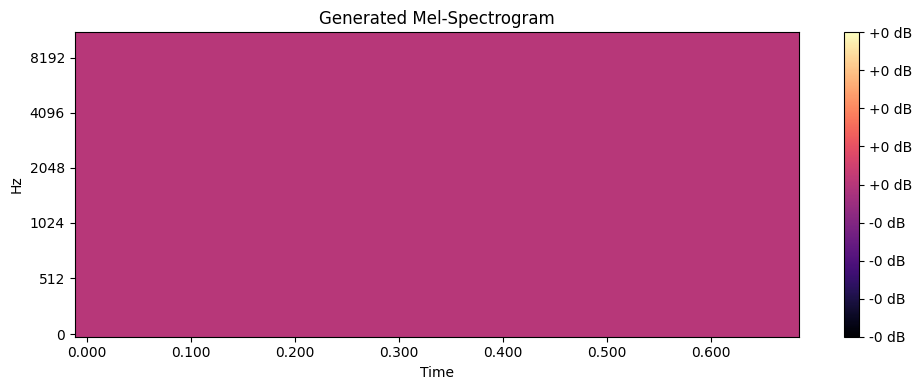

In [24]:
# Plot Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(predicted_mel.T, sr=22050, x_axis="time", y_axis="mel")
plt.title("Generated Mel-Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


## **Key Features**

- **Text-to-Speech Pipeline**: Implements a simple TTS model with text embedding and spectrogram generation.
- **Customizable Architecture**: The model supports configurable input dimensions, vocabulary size, and mel spectrogram settings.
- **Audio Synthesis**: Generates realistic audio using the Griffin-Lim vocoder.
- **Visualization**: Provides visual inspection of the generated mel spectrograms.

## **Applications**

- **Voice Assistants**: Basis for building conversational AI systems.
- **Audiobook Generation**: Converts text into narrated audio.
- **Accessibility Tools**: Helps visually impaired individuals by converting written text into speech.

---